In [67]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.models import load_model
import random
import os
import shutil
from PIL import Image
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.python.client import device_lib
from collections import defaultdict
import cv2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau


In [109]:

device_lib.list_local_devices()


[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 14021842665622484540
 xla_global_id: -1,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 2245525504
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 2849392827875896345
 physical_device_desc: "device: 0, name: NVIDIA GeForce GTX 1650 Ti with Max-Q Design, pci bus id: 0000:01:00.0, compute capability: 7.5"
 xla_global_id: 416903419]

In [110]:

def count_pictures_in_classes(folder_path):
    class_counts = defaultdict(int)

    for root, dirs, files in os.walk(folder_path):
        for file in files:
                 class_name = os.path.basename(root)
                 class_counts[class_name] += 1

    return dict(class_counts)



def plot_class_counts(class_counts):
    classes = list(class_counts.keys())
    counts = list(class_counts.values())
    plt.figure(figsize=(20,10))

    plt.bar(classes, counts, color='blue')
    plt.xlabel('Class Name')
    plt.ylabel('Number of Pictures')
    plt.title('Picture Counts in Each Class')
    plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better visibility
    plt.tight_layout()
    plt.show()



Class Counts: {'Alluvial soil': 523, 'Black Soil': 228, 'Clay soil': 197, 'Red soil': 267}


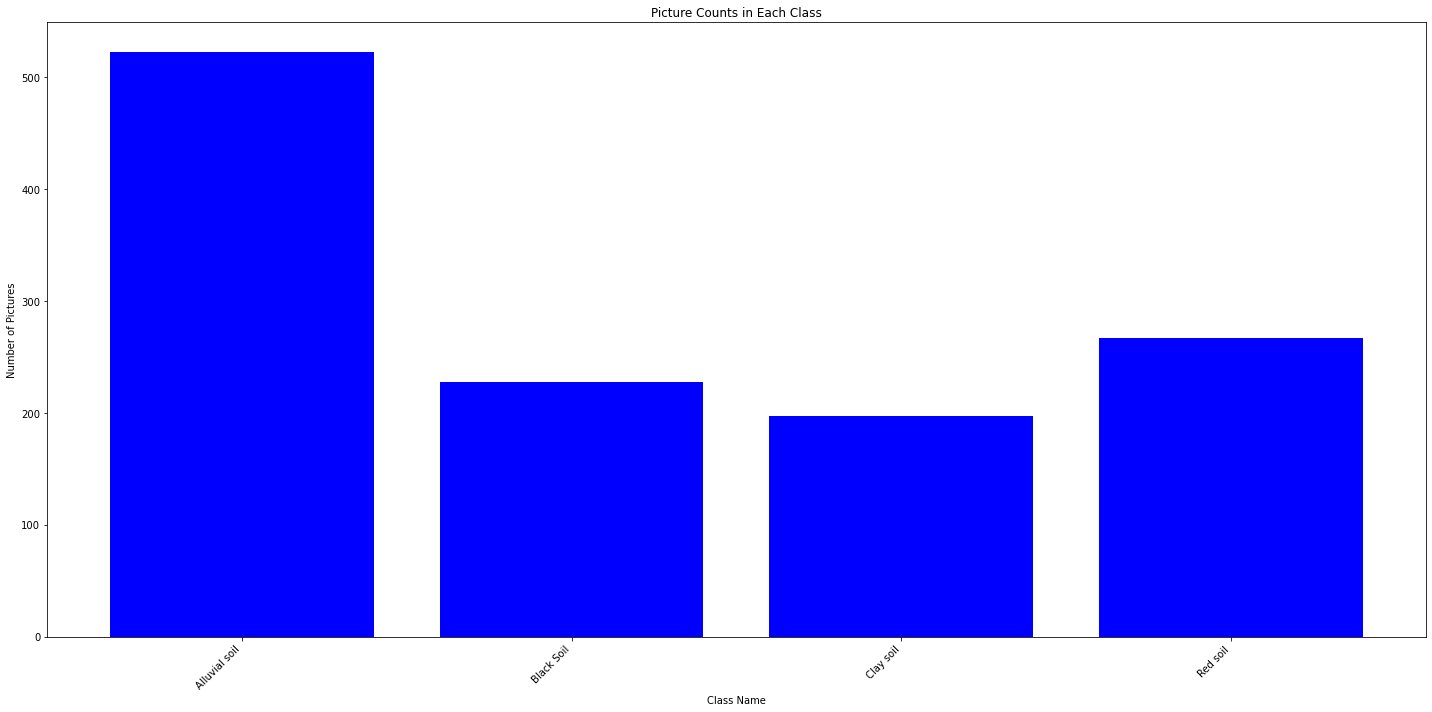

In [111]:
folder_path = r"E:\Users\ahmed\OneDrive\Desktop\graduation_model_v2\visionmodel_soil\Train_soil"
class_counts = count_pictures_in_classes(folder_path)
print("Class Counts:", class_counts)
plot_class_counts(class_counts)

Class Counts: {'Alluvial soil': 53, 'Black Soil': 116, 'Clay soil': 65, 'Red soil': 106}


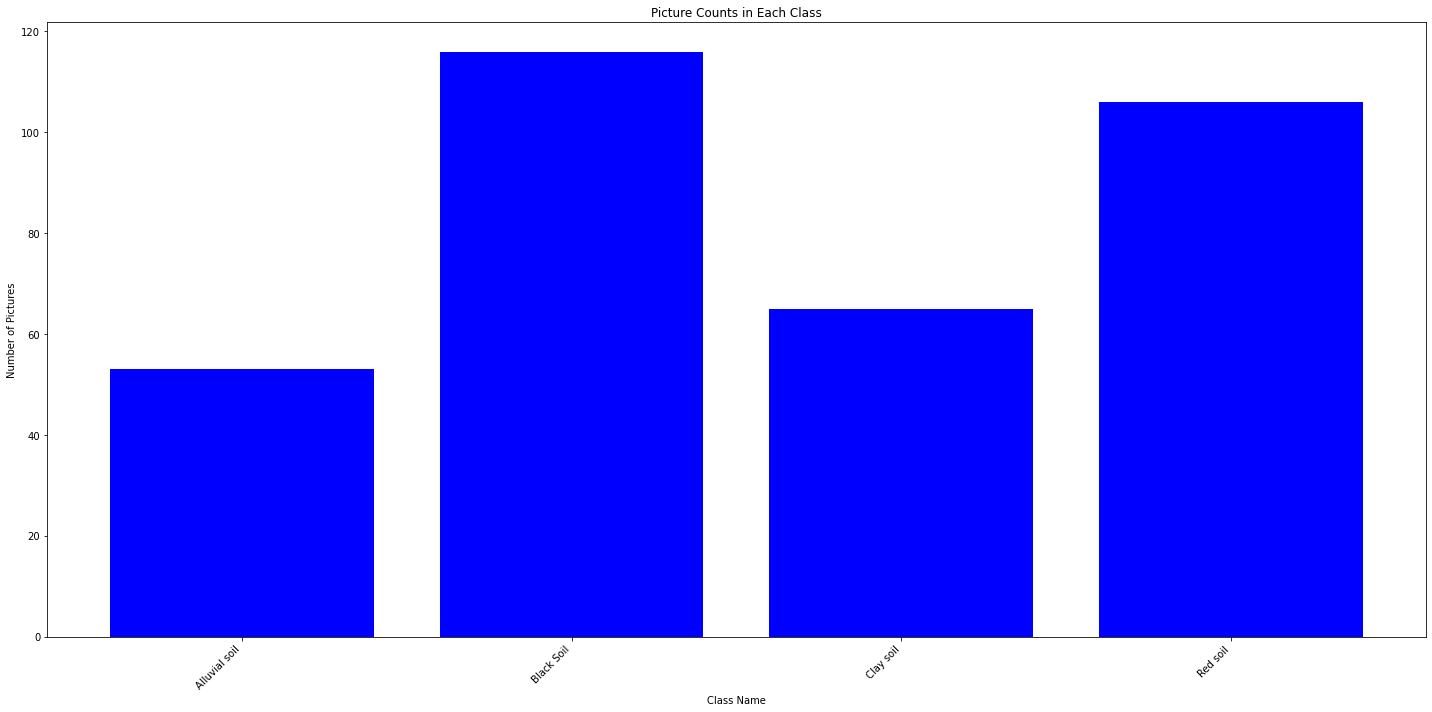

In [112]:
folder_path = r"E:\Users\ahmed\OneDrive\Desktop\graduation_model_v2\visionmodel_soil\test_soil"
class_counts = count_pictures_in_classes(folder_path)
print("Class Counts:", class_counts)
plot_class_counts(class_counts)

In [128]:
imsize=256
batch=64
chanels=3
epoch=70
n_classes=4


In [129]:
train_data = tf.keras.preprocessing.image_dataset_from_directory(
    r"E:\Users\ahmed\OneDrive\Desktop\graduation_model_v2\visionmodel_soil\Train_soil",
    shuffle=True,
    image_size=(imsize, imsize),
    batch_size=batch,
)



Found 1215 files belonging to 4 classes.


In [130]:
validation_data=tf.keras.preprocessing.image_dataset_from_directory(
     r"E:\Users\ahmed\OneDrive\Desktop\graduation_model_v2\visionmodel_soil\test_soil",
    shuffle=True,
    image_size=(imsize,imsize),
    batch_size=batch,
    

    )

 

Found 340 files belonging to 4 classes.


In [131]:
 def split_data(ds,val_split=0.50,test_split=0.50,shuffle=True,shuffle_size=10000):
    
    ds_size=len(ds)
    
    if shuffle:
        ds.shuffle(shuffle_size,seed=5)
        
    val_size=int(val_split*ds_size)
    
    val_ds=ds.take(val_size)
    test_ds=ds.skip(val_size)
    
    
    return val_ds,test_ds
    
    
    
    
    

In [132]:
val_ds,test_ds= split_data(validation_data)


In [133]:
class_name=train_data.class_names
class_name

['Alluvial soil', 'Black Soil', 'Clay soil', 'Red soil']

In [134]:
for im_batch,lebal in train_data.take(1):
    print(im_batch.shape)
    print(lebal.numpy())

(64, 256, 256, 3)
[0 0 0 2 0 0 1 3 0 1 3 3 3 0 1 0 3 0 2 0 0 2 0 2 0 0 0 0 0 3 2 3 1 0 2 1 3
 1 3 3 1 3 0 0 0 0 0 2 1 3 3 2 2 0 0 3 0 0 1 3 0 3 0 0]


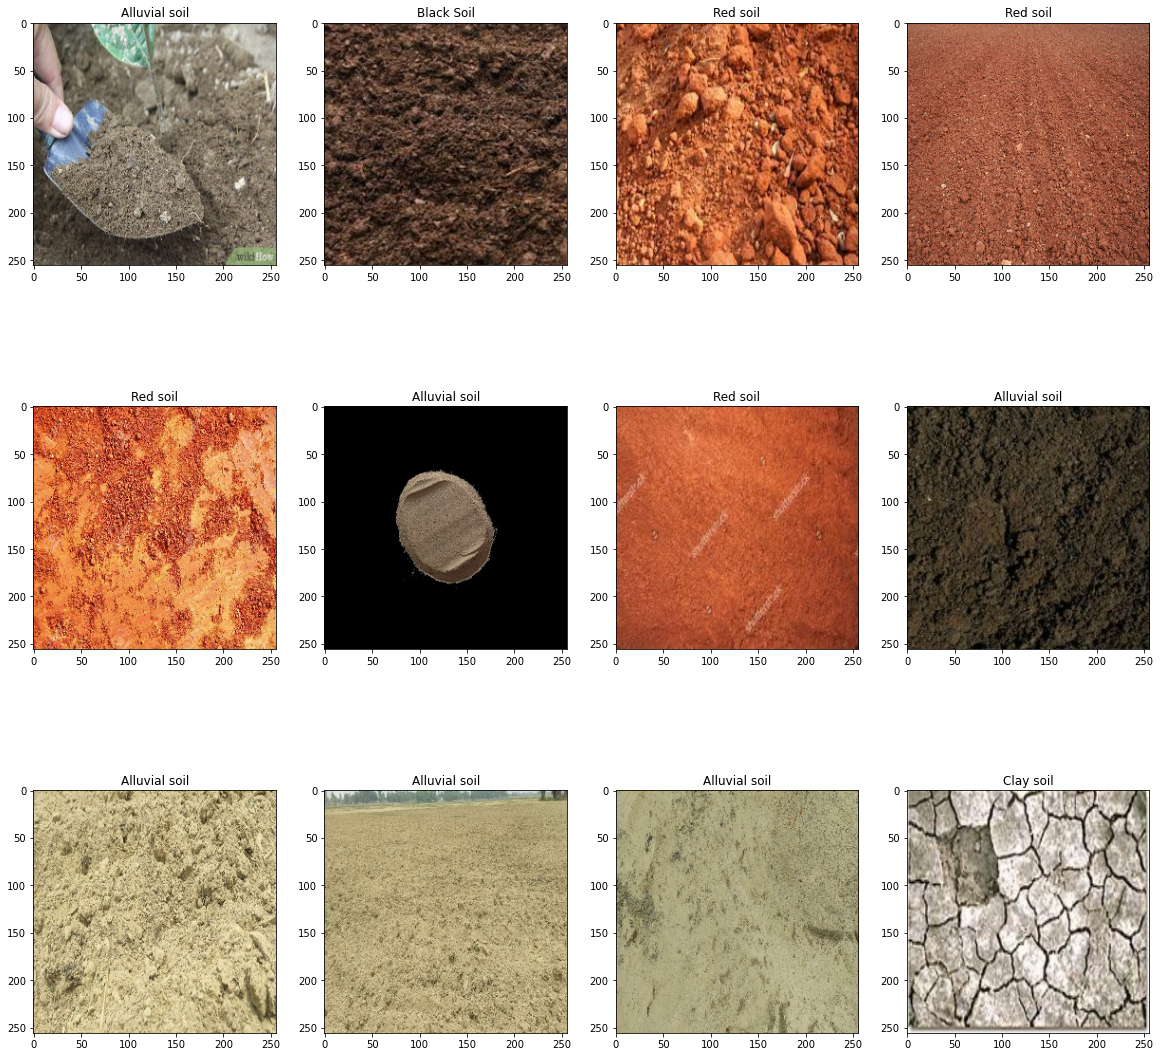

In [135]:
plt.figure(figsize=(20,20))
for im_batch,lebal in train_data.take(1):
    for i in  range(12):
        plt.subplot(3,4,i+1)
        plt.title(class_name[lebal[i]])
        plt.imshow(im_batch[i].numpy().astype("uint8"))

In [163]:
resize_and_rescale=tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(imsize,imsize),
    layers.experimental.preprocessing.Rescaling(1.0/255)    
    
])
data_augmentation=tf.keras.Sequential([
    layers.experimental.preprocessing.RandomZoom(0.2),
    layers.experimental.preprocessing.RandomContrast(0.2),
    layers.experimental.preprocessing.RandomTranslation(0.2, 0.2)

    

    
    
])

In [164]:
input_shape=(batch,imsize,imsize,chanels)
model=models.Sequential ([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32,(3,3),activation="relu",input_shape=input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation="relu"),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(128,(3,3),activation="relu"),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(128,(3,3),activation="relu"),
    layers.MaxPooling2D((2,2)),
 

    layers.Flatten(),
    layers.Dense(128,activation="relu"),
    layers.Dense(n_classes,activation='softmax'),


])

In [165]:
model.build(input_shape=input_shape)

In [166]:
model.summary()

Model: "sequential_30"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_28 (Sequential)  (64, 256, 256, 3)         0         
                                                                 
 sequential_29 (Sequential)  (None, 256, 256, 3)       0         
                                                                 
 conv2d_50 (Conv2D)          (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d_50 (MaxPoolin  (None, 127, 127, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_51 (Conv2D)          (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_51 (MaxPoolin  (None, 62, 62, 64)       0         
 g2D)                                                

In [167]:
model.compile(
    optimizer="adam",
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=["accuracy"]


)

In [168]:
history=model.fit(
    train_data,
    epochs=epoch,
    batch_size=batch,
    verbose=1,
    validation_data=val_ds,
 


)




Epoch 1/70
19/19 [==============================] - 35s 1s/step - loss: 1.3250 - accuracy: 0.4354 - val_loss: 1.2879 - val_accuracy: 0.4115
Epoch 2/70
19/19 [==============================] - 29s 1s/step - loss: 0.8152 - accuracy: 0.6461 - val_loss: 0.6485 - val_accuracy: 0.7969
Epoch 3/70
19/19 [==============================] - 29s 1s/step - loss: 0.6038 - accuracy: 0.7646 - val_loss: 0.7927 - val_accuracy: 0.7500
Epoch 4/70
19/19 [==============================] - 29s 2s/step - loss: 0.5574 - accuracy: 0.7778 - val_loss: 0.5725 - val_accuracy: 0.8073
Epoch 5/70
19/19 [==============================] - 29s 1s/step - loss: 0.4638 - accuracy: 0.8107 - val_loss: 0.4358 - val_accuracy: 0.8333
Epoch 6/70
19/19 [==============================] - 29s 1s/step - loss: 0.4524 - accuracy: 0.8008 - val_loss: 0.3174 - val_accuracy: 0.8750
Epoch 7/70
19/19 [==============================] - 30s 2s/step - loss: 0.4035 - accuracy: 0.8181 - val_loss: 0.4345 - val_accuracy: 0.8385
Epoch 8/70
19/19 [==

In [169]:
score=model.evaluate(test_ds)

3/3 [==============================] - 1s 63ms/step - loss: 0.0693 - accuracy: 0.9662


In [170]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [171]:
acc=history.history["accuracy"]
val_acc=history.history["val_accuracy"]
loss=history.history["loss"]
val_loss=history.history["val_loss"]

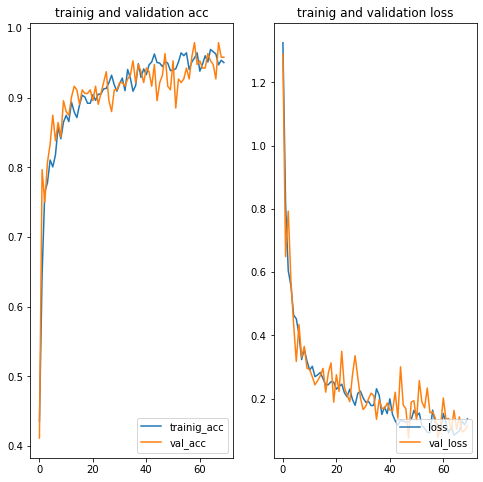

In [172]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(70),acc,label="trainig_acc")
plt.plot(range(70),val_acc,label="val_acc")
plt.legend(loc="lower right")
plt.title("trainig and validation acc")

plt.subplot(1,2,2)
plt.plot(range(70),loss,label="loss")
plt.plot(range(70),val_loss,label="val_loss")
plt.legend(loc="lower right")
plt.title("trainig and validation loss")


plt.show()

actul_label:  Black Soil
2/2 [==============================] - 0s 255ms/step
predicted:  Black Soil


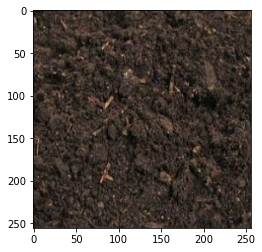

In [173]:
for im_batch,lebal in test_ds.take(1):
  first_im=im_batch[0].numpy().astype("uint8")
  first_label=lebal[0].numpy()
  plt.imshow(first_im)

  print("actul_label: ",class_name[first_label])
  prediction=model.predict(im_batch)
  print("predicted: ",class_name[np.argmax(prediction[0])])


In [174]:
 def predict(model,img):
   img_array=tf.keras.preprocessing.image.img_to_array(images[i].numpy())
   img_array=tf.expand_dims(img_array,0)

   prediction=model.predict(img_array)
   predicted_class=class_name[np.argmax(prediction[0])]
   confidence=round(100*(np.max(prediction[0])),2)
   return predicted_class,confidence


1/1 [==============================] - 0s 18ms/step


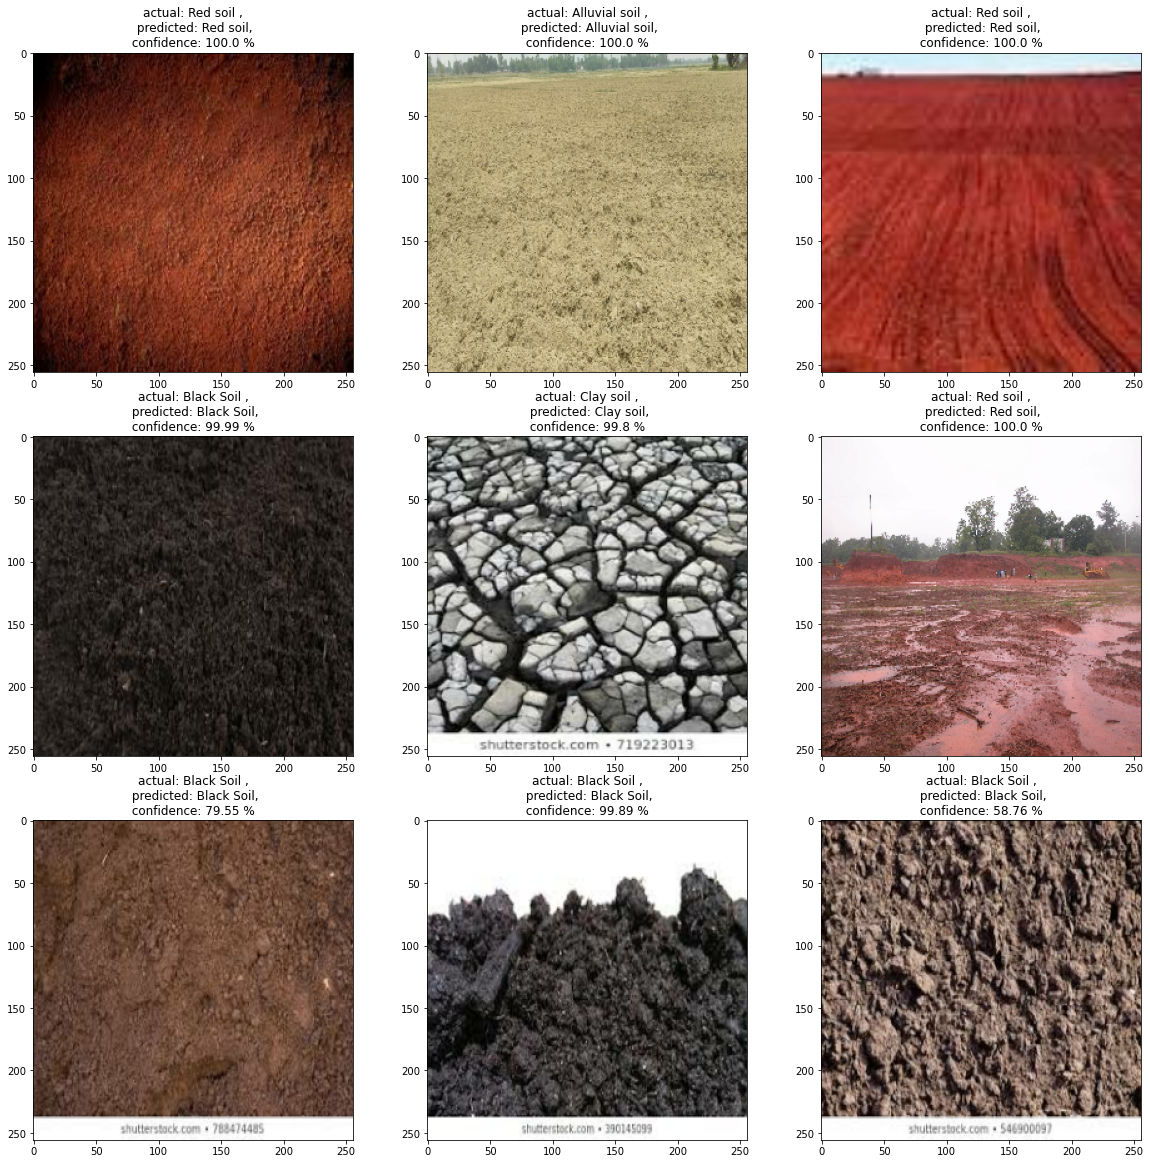

In [175]:
plt.figure(figsize=(20,20))
for images,labels in test_ds.take(1):
  for i in range(9):
    ax=plt.subplot(3,3,i+1)
    plt.imshow(images[i].numpy().astype("uint8"))

    predicted_class,confidence=predict(model,images[i].numpy())
    actual_class=class_name[labels[i]]
    plt.title(f"actual: {actual_class} ,\n predicted: {predicted_class},\n confidence: {confidence} % ")

In [176]:
labels = []
predictions = []
for x,y in test_ds:
    labels.append(list(y.numpy()))
    predictions.append(tf.argmax(model.predict(x),1).numpy())

1/1 [==============================] - 0s 19ms/step


In [177]:
import itertools

predictions = list(itertools.chain.from_iterable(predictions))
labels = list(itertools.chain.from_iterable(labels))

In [178]:
from sklearn.metrics import accuracy_score,precision_score,recall_score

print("Train Accuracy  : {:.2f} %".format(history.history['accuracy'][-1]*100))
print("Test Accuracy   : {:.2f} %".format(accuracy_score(labels, predictions) * 100))
print("Precision Score : {:.2f} %".format(precision_score(labels, predictions, average='micro') * 100))
print("Recall Score    : {:.2f} %".format(recall_score(labels, predictions, average='micro') * 100))

Train Accuracy  : 95.06 %
Test Accuracy   : 94.59 %
Precision Score : 94.59 %
Recall Score    : 94.59 %


<Figure size 1440x360 with 0 Axes>

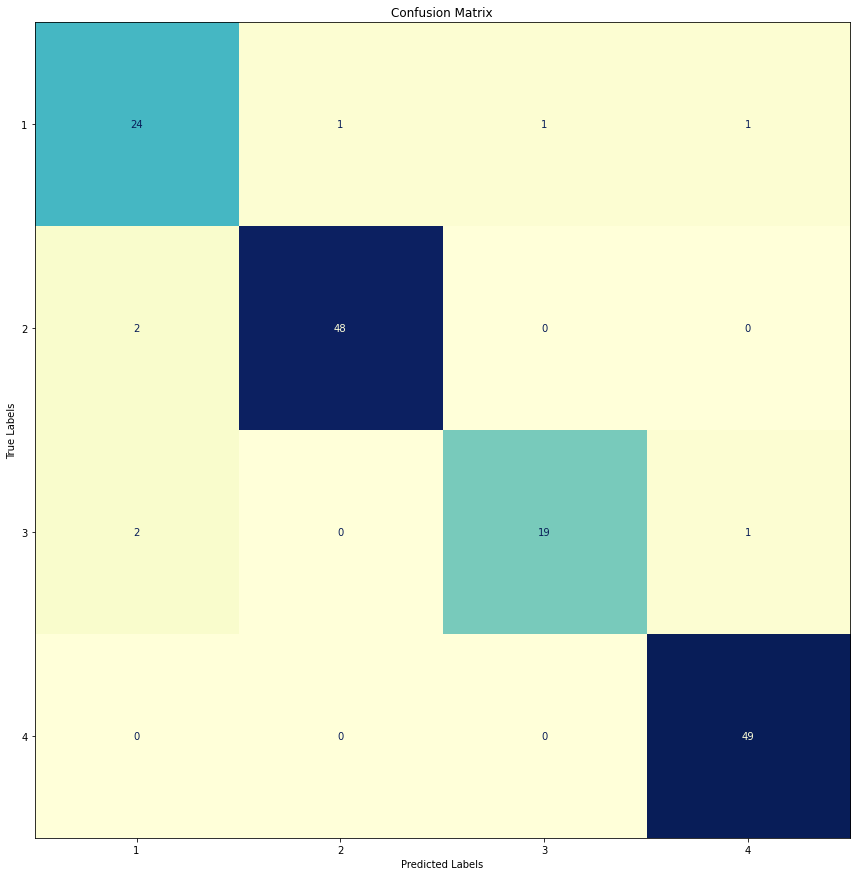

In [179]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

plt.figure(figsize= (20,5))
cm = confusion_matrix(labels, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=list(range(1,5)))
fig, ax = plt.subplots(figsize=(15,15))
disp.plot(ax=ax,colorbar= False,cmap = 'YlGnBu')
plt.title("Confusion Matrix")
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show() 

In [180]:
from sklearn.metrics import classification_report

class_name=np.array(train_data.class_names)
class_name
print(classification_report(labels, predictions, target_names=class_name))


               precision    recall  f1-score   support

Alluvial soil       0.86      0.89      0.87        27
   Black Soil       0.98      0.96      0.97        50
    Clay soil       0.95      0.86      0.90        22
     Red soil       0.96      1.00      0.98        49

     accuracy                           0.95       148
    macro avg       0.94      0.93      0.93       148
 weighted avg       0.95      0.95      0.95       148



In [184]:
from keras.models import load_model

model.save(r'E:\Users\ahmed\OneDrive\Desktop\graduation_model_v2\visionmodel_soil/soil_model.h5')